In [1]:
from sklearn import metrics## ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.tri as tri
from scipy import stats
from scipy.special import gamma as gamma_fun
from scipy.integrate import odeint
import scipy.special as spec
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
np.set_printoptions(suppress=True)
import timeit


from deep_bayes.models import DeepEvidentialModel, MCDropOutModel, SoftmaxModel, VAE
from deep_bayes.settings import SOFTMAX_EPI, VAE_EPI, DROPOUT_EPI,EVIDENTIAL_HH5
from deep_bayes.training import train_online, train_online_vae, train_online_dropout, train_online_softmax
from deep_bayes.losses import log_loss
from deep_bayes.viz import plot_model_samples, plot_confusion_matrix
from deep_bayes.diagnostics import accuracy, overconfidence, expected_calibration_error

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
tf.enable_eager_execution()

In [5]:
%matplotlib inline

# Generative model specifications

## Model prior 
<p>Defines the prior probabilities over models $p(\boldsymbol{m})$.</p>

In [6]:
def model_prior(batch_size, n_models, p_vals=None):
    """
    Samples from the models' prior batch size times and converts to one-hot.
    Assumes equal model priors.
    ----------
    
    Arguments:
    batch_size : int  -- the number of samples to draw from the prior
    n_models   : int  -- the number of generative models in queston
    ----------
    
    Returns:
    m_true : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Equal priors, if nothign specified
    if p_vals is None:
        p_vals = [1/n_models] * n_models
    m_idx = np.random.choice(n_models, size=batch_size, p=p_vals).astype(np.int32)
    return m_idx

## Model parameters priors
<p>Defines how parameters are generated given a model $p(\boldsymbol{\theta}|\boldsymbol{m})$.</p>

In [7]:
def SIR_basic_prior(**args):
    
    theta = (
        np.random.uniform(low=0.001, high=1.0), # beta
        np.random.uniform(low=0.001, high=1.0), # gamma
    )
    return theta


def SIR_vitalDynamics_prior(**args):
 
    theta = (
        np.random.uniform(low=0.001, high=0.1), # mu
        np.random.uniform(low=0.001, high=0.1), # omega
        np.random.uniform(low=0.001, high=1.0), # beta
        np.random.uniform(low=0.001, high=1.0), # gamma
    )
    return theta


def SIRS_basic_prior(**args):

    theta = (
        np.random.uniform(low=0.001, high=1.0), # beta
        np.random.uniform(low=0.001, high=1.0), # gamma
        np.random.uniform(low=0.025, high=0.1), # xi
    )
    return theta

def SIRS_vitalDynamics_prior(**args):

    theta = (
        np.random.uniform(low=0.001, high=0.1), # mu
        np.random.uniform(low=0.001, high=0.1), # omega
        np.random.uniform(low=0.001, high=1.0), # beta
        np.random.uniform(low=0.001, high=1.0), # gamma
        np.random.uniform(low=0.025, high=0.1), # xi
    )
    return theta

def SIRS_IncidenceRate_prior(**args):

    theta = (
        np.random.uniform(low=0.001, high=0.1), # mu
        np.random.uniform(low=0.001, high=0.1), # omega
        np.random.uniform(low=0.001, high=1.0), # gamma
        np.random.uniform(low=0.025, high=0.1), # xi
        np.random.uniform(low=0.01, high=5.0), # k
        np.random.uniform(low=0.01, high=5.1), # alpha
    )
    return theta

## Generative models
<p>Defines how the data are generated, that is, $\boldsymbol{x}_{1:N} \sim p(\boldsymbol{x}| \boldsymbol{\theta},\boldsymbol{m}).$

In [8]:
def SIR_basic(params, n_obs, N=500, I0=1, R0=0, **args):
    
    # beta: infectious rate
    # gamma: recovery rate
    
    beta, gamma = params
    S0 = N - I0 - R0 # Initial susceptibles
    
    t = np.linspace(0, n_obs, n_obs)
    
    # differential equations.
    def deriv(y, t, N, beta, gamma):
        S, I, R = y
        dS = -beta * S * I / N
        dI = beta * S * I / N - gamma * I
        dR = gamma * I
        return dS, dI, dR
    
    # Initial conditions vector
    y0 = S0, I0, R0
    
    # Integrate .
    out = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = out.T
    
    return np.c_[S,I,R]


def SIR_vitalDynamics(params, n_obs, N=500, I0=1, R0=0, **args):
    
    # mu: birth rate
    # omega: death rate
    # beta: infectious rate
    # gamma: recovery rate
    
    mu, omega, beta, gamma = params
    S0 = N - I0 - R0 # Initial susceptibles
    
    t = np.linspace(0, n_obs, n_obs)
    
    # differential equations.
    def deriv(y, t, N, mu, omega, beta, gamma):
        S, I, R = y
        dS = mu*N - beta * S * I / N - omega*S
        dI = beta * S * I / N - gamma * I - omega*I
        dR = gamma * I - omega*R
        return dS, dI, dR
    
    # Initial conditions vector
    y0 = S0, I0, R0
    
    # Integrate 
    out = odeint(deriv, y0, t, args=(N, mu, omega, beta, gamma))
    S, I, R = out.T
    
    return np.c_[S,I,R]

def SIRS_basic(params, n_obs, N=500, I0=1, R0=0, **args):
    
    # beta: contact rate
    # gamma: infectious rate
    # xi: immunity loss rate
    
    beta, gamma, xi = params
    S0 = N - I0 - R0 # Initial susceptibles
    
    t = np.linspace(0, n_obs, n_obs)
    
    # differential equations.
    def deriv(y, t, N, beta, gamma, xi):
        S, I, R = y
        dS = -beta * S * I / N + xi*R
        dI = beta * S * I / N - gamma * I
        dR = gamma * I - xi*R
        return dS, dI, dR
    
    # Initial conditions vector
    y0 = S0, I0, R0
    
    # Integrate .
    out = odeint(deriv, y0, t, args=(N, beta, gamma, xi))
    S, I, R = out.T
    
    return np.c_[S,I,R]

def SIRS_vitalDynamics(params, n_obs, N=500, I0=1, R0=0, **args):
    
    # mu: birth rate
    # omega: death rate
    # beta: infectious rate
    # gamma: recovery rate
    # xi: immunity loss 
    
    mu, omega, beta, gamma, xi = params
    S0 = N - I0 - R0 # Initial susceptibles
    
    t = np.linspace(0, n_obs, n_obs)
    
    # differential equations.
    def deriv(y, t, N, mu, omega, beta, gamma, xi):
        S, I, R = y
        dS = mu*N - beta * S * I / N + xi*R - omega*S
        dI = beta * S * I / N - gamma * I - omega*I
        dR = gamma * I - xi*R - omega*R
        return dS, dI, dR
    
    # Initial conditions vector
    y0 = S0, I0, R0
    
    # Integrate 
    out = odeint(deriv, y0, t, args=(N, mu, omega, beta, gamma, xi))
    S, I, R = out.T
    
    return np.c_[S,I,R]

def SIRS_IncidenceRate(params, n_obs, N=500, I0=1, R0=0, **args):
    
    # mu: birth rate
    # omega: death rate
    # gamma: recovery rate
    # xi: immunity loss 
    # k: infectious force
    # alpha: inhibition effect
    
    mu, omega, gamma, xi, k, alpha = params
    S0 = N - I0 - R0 # Initial susceptibles
    
    t = np.linspace(0, n_obs, n_obs)
    
    # differential equations.
    def deriv(y, t, N, mu, omega, gamma, xi, k, alpha):
        S, I, R = y
        dS = mu*N - S*(k*I**2)/(1+alpha*I**2) + xi*R - omega*S
        dI = S*(k*I**2)/(1+alpha*I**2) - gamma * I - omega*I
        dR = gamma * I - xi*R - omega*R
        return dS, dI, dR
    
    # Initial conditions vector
    y0 = S0, I0, R0
    
    # Integrate 
    out = odeint(deriv, y0, t, args=(N, mu, omega, gamma, xi, k, alpha))
    S, I, R = out.T
    
    return np.c_[S,I,R]

## Data generator
<p>Define the algorithm:</p>
1. <strong>for</strong> $i = 1,...,B$<br>
2. &emsp;$\boldsymbol{m}^{(i)} \sim p(\boldsymbol{m})$<br>
3. &emsp;$\boldsymbol{\theta}^{(i)} \sim p(\boldsymbol{\theta}|\boldsymbol{m}^{(i)})$<br>
4. &emsp;$\boldsymbol{x}_{1:N}^{(i)} \sim p(\boldsymbol{x}|\boldsymbol{\theta}^{(i)},\boldsymbol{m}^{(i)})$

In [9]:
def data_generator(batch_size, model_prior, param_priors, forward_models, alpha_smooth=None,
                   n_obs=None, n_obs_min=100, n_obs_max=500, to_tensor=True, **args):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size     : int -- the number of samples to draw from the prior
    model_prior    : callable -- the prior which returns a sample of model indices
    param_priors   : list of callables -- a list with model prior samplers
    forward_models : list of generative models g(theta) -- a list of generatibve models
    alpha_smooth   : float or None -- the label smoothing hyperparameter
    n_obs          : int -- the numebr of observations to draw from p(x|theta)
    n_obs_min      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    n_obs_max      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    to_tensor      : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    m     : tf.Tensor or np.ndarray of shape (batch_size, n_models) - the one-hot encoded version of the models
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    # Sample from model prior
    # m_indices is an np.int32 array of model indices  
    n_models = len(forward_models)
    m_indices = model_prior(batch_size, n_models)
    
    # Sample N, if not specified
    if n_obs is None:
        n_obs = np.random.randint(low=n_obs_min, high=n_obs_max+1)
    
    # For each model index, sample from prior and run generative model.
    x = []
    theta = []
    for m_idx in m_indices:
        
        # Draw from model prior theta ~ p(theta|
        theta_m = param_priors[m_idx]()
        
        # Generate data from x = g_m(theta) <=> x ~ p(x|theta,m)
        x_m = forward_models[m_idx](theta_m, n_obs)
        
        # Store data and params
        x.append(x_m)
        theta.append(theta_m)
    
    # One-hot encode model indices
    m = to_categorical(m_indices, num_classes=n_models)
    
    # Apply label smoothing, if specified
    if alpha_smooth is not None:
        m = m * (1 - alpha_smooth) + alpha_smooth / n_models
    
    # Convert to tensor, if specified 
    if to_tensor:
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        m = tf.convert_to_tensor(m, dtype=tf.float32)
    return {'m': m, 'theta': theta, 'x': x}

## Utility

In [10]:
def plot_calibration(model, test_data_c, model_names, n_chunks=10, n_bins=15):
    
    # Compute probabilities and calibrations
    preds = np.concatenate([model.predict(x, to_numpy=True)['m_probs'] 
                            for x in tf.split(test_data_c['x'], n_chunks, axis=0)], axis=0)
    cal_errs, cal_probs = expected_calibration_error(test_data_c['m'], preds, n_bins=n_bins)
    
    # Plot calibration curves
    f, axarr = plt.subplots(1, 5, figsize=(12, 3))
    for i, ax in enumerate(axarr.flat):
        ax.plot(cal_probs[i][0], cal_probs[i][1])
        ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_title(model_names[i])
        ax.set_xlabel('Accuracy')
        ax.set_ylabel('Confidence')
        ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    f.tight_layout()
    plt.show()

# Training hyperparameters

In [11]:
#--- Training hyperparameters ---#
ckpt_file = "epidemiology_model_selection_five"
batch_size = 64
epochs = 20
iterations_per_epoch = 100
alpha_smooth = None
n_obs_min = 50
n_obs_max = 150
n_obs = 100
n_test = 500
n_test_cal = 5000


#--- Optimizer hyperparameters ---#
starter_learning_rate = 0.0005
global_step = tfe.Variable(0, dtype=tf.int32)
decay_steps = 5000
decay_rate = .9
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)


#--- Generative model hyperparameters ---#
model_names = ['SIR','SIR-VD','SIRS','SIRS-VD', 'SIRS-IR']

param_priors = [SIR_basic_prior,
                SIR_vitalDynamics_prior,
                SIRS_basic_prior,
                SIRS_vitalDynamics_prior, 
                SIRS_IncidenceRate_prior]

forward_models = [SIR_basic, 
                  SIR_vitalDynamics,
                  SIRS_basic,
                  SIRS_vitalDynamics, 
                  SIRS_IncidenceRate]


data_gen = partial(data_generator, 
                   model_prior=model_prior, 
                   param_priors=param_priors,
                   forward_models=forward_models,
                   alpha_smooth=alpha_smooth,
                   n_obs_min=n_obs_min,
                   n_obs_max=n_obs_max,
                   n_obs=200)

## Create test data

In [12]:
%%time
test_data_c = data_gen(n_test_cal, n_obs=200)
test_data = data_gen(n_test, n_obs=200)

CPU times: user 17 s, sys: 167 ms, total: 17.2 s
Wall time: 18.7 s


## Create model

In [13]:
model = DeepEvidentialModel(EVIDENTIAL_HH5)

## Manage checkpoints

In [14]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


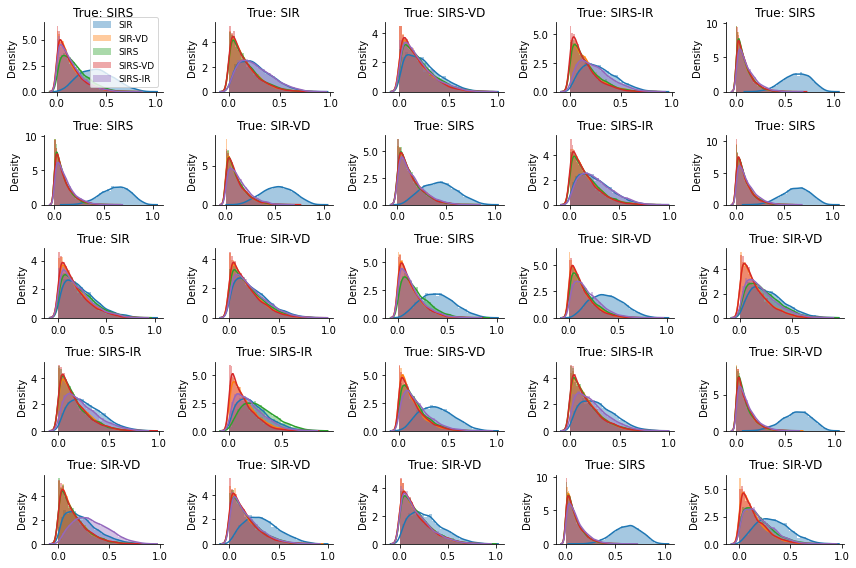

In [15]:
#run and plot performance of untrained networks
plot_model_samples(model, 
                       x_test=test_data['x'][:25], 
                       m_test=test_data['m'][:25], 
                       model_names=model_names,
                       figsize=(12, 8))

# Train network

Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


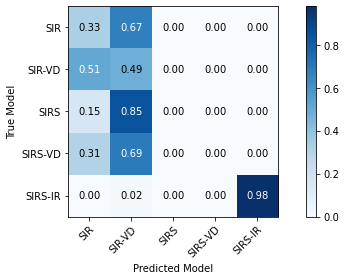

0.338


Training epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

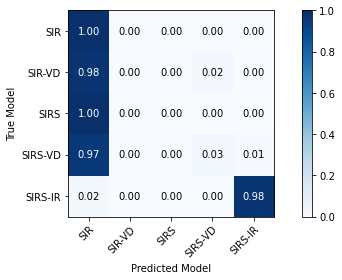

0.358


Training epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

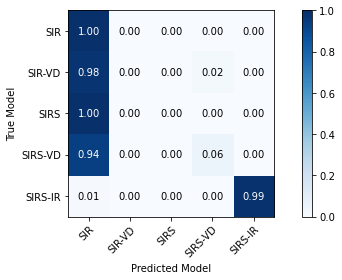

0.368


Training epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

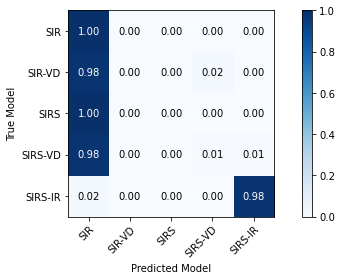

0.354


Training epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

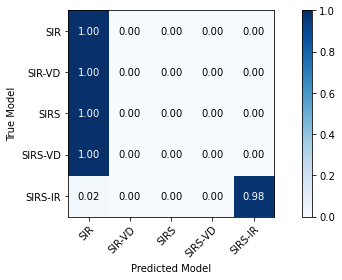

0.352


Training epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

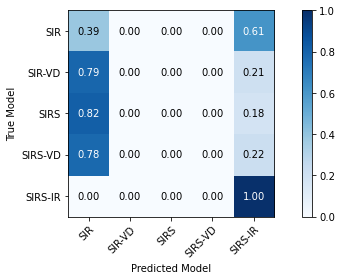

0.254


Training epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]

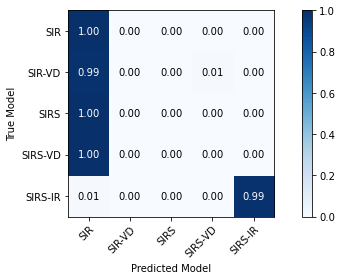

0.354


Training epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]

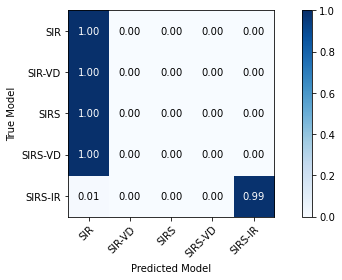

0.354


Training epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]

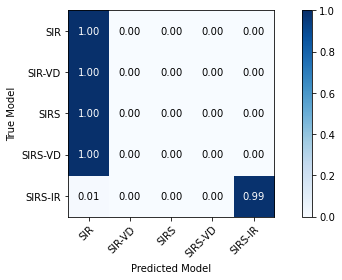

0.354


Training epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]

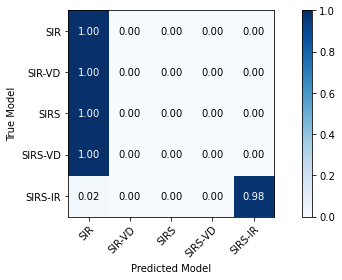

0.352


Training epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]

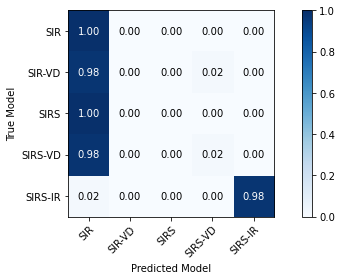

0.356


Training epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]

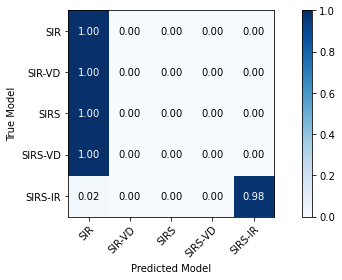

0.352


Training epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]

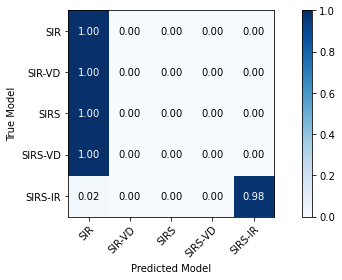

0.352


Training epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]

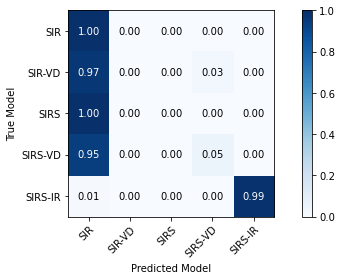

0.366


Training epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]

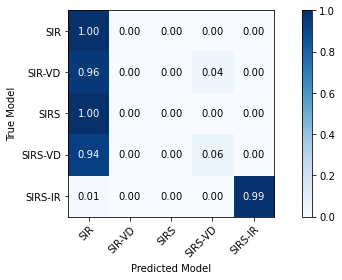

0.368


Training epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]

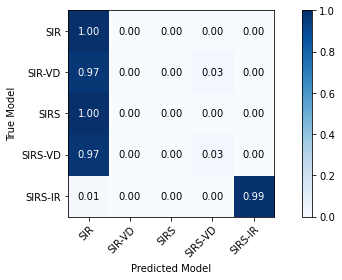

0.36


Training epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]

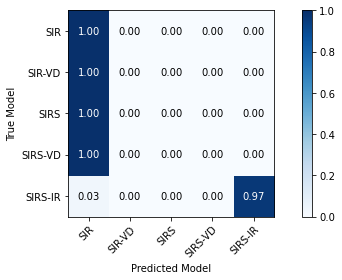

0.35


Training epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]

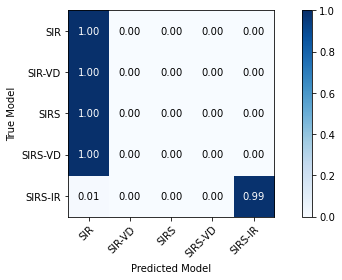

0.354


Training epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]

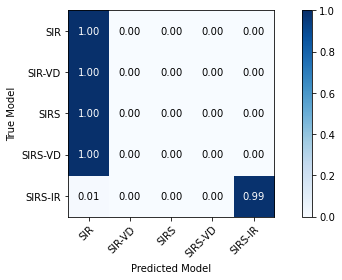

0.354


Training epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]

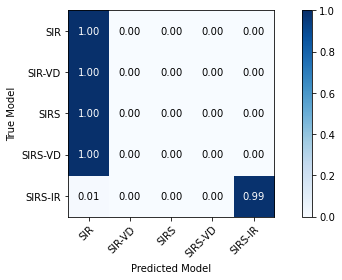

0.354
CPU times: user 2h 39min 26s, sys: 4min 41s, total: 2h 44min 7s
Wall time: 2h 7min 42s


In [16]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online(model=model, 
                              optimizer=optimizer, 
                              data_gen=data_gen, 
                              loss_fun=partial(log_loss, lambd=0.0), 
                              iterations=iterations_per_epoch,
                              batch_size=batch_size,
                              p_bar=p_bar,
                              global_step=global_step,
                              method='evidence')
        
        
        # Plot stuff
        m_pred = model(test_data['x'])['m_probs']
        plot_confusion_matrix(m_pred.numpy().argmax(axis=1), test_data['m'], model_names, figsize=(8,4),normalize=True)
        print(accuracy(test_data['m'], m_pred))

        # Store checkpoint
        manager.save()

In [17]:
#test_data['x'][0].numpy()

In [18]:
#test_data['m']

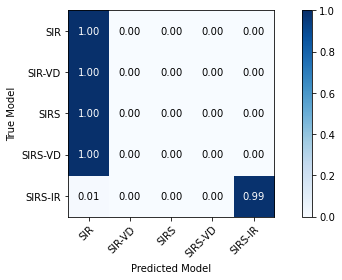

0.354


In [19]:
m_pred = model(test_data['x'])['m_probs']
plot_confusion_matrix(m_pred.numpy().argmax(axis=1), test_data['m'], model_names, figsize=(8,4),normalize=True)

print(accuracy(test_data['m'], m_pred))

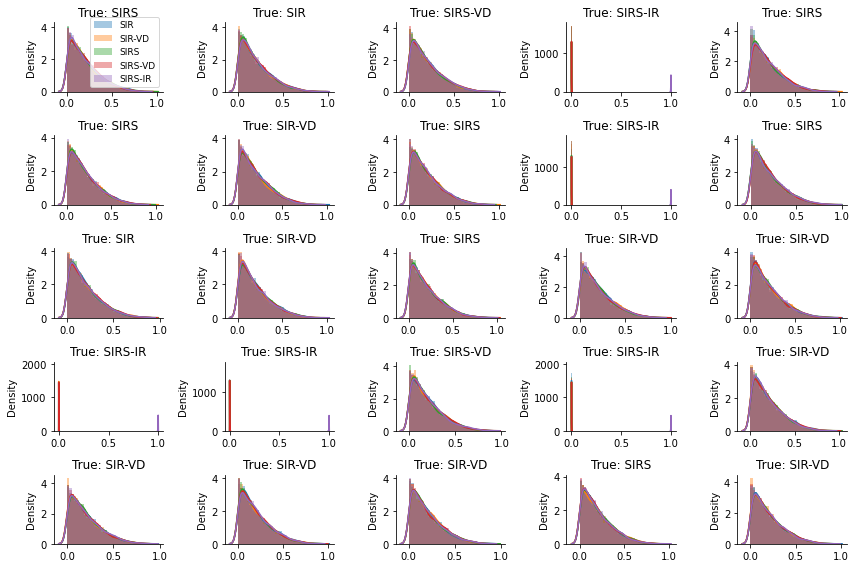

In [20]:
plot_model_samples(model, 
                       x_test=test_data['x'][:25], 
                       m_test=test_data['m'][:25], 
                       model_names=model_names,
                       figsize=(12, 8))

In [21]:
print(accuracy(test_data['m'], m_pred))
print(expected_calibration_error(test_data['m'], m_pred))
print(overconfidence(test_data['m'], m_pred))

0.354
([0.0024893372837184206, 0.024656824968447486, 0.02835140679199115, 0.04436125846598442, 0.09985883516228158], [(array([0.       , 0.2044335]), array([0.00054518, 0.2       ])), (array([0.        , 0.24876847]), array([0.00054518, 0.2       ])), (array([0.        , 0.25615764]), array([0.00054518, 0.2       ])), (array([0.        , 0.28817734]), array([0.00054518, 0.2       ])), (array([0.00246305, 1.        ]), array([0.2       , 0.99781928]))])
0
